As we did in previous chapters, let's define the default font sizes to make the figures prettier:

In [2]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

And let's creat the `images/dim_reduction` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures.

In [3]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "dim_reduction" 
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## PCA  (Principal Components Analysis)--------------------------------

 

In [4]:
import numpy as np
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * np.random.randn(m, 3)  # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X += [0.2, 0, 0.2]  # shift a bit


In [5]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt[0]
c2 = Vt[1]

Note: in principal, the SVD factorization algorithm returns three matrices **U, Σ**and **V**, such that **$X = UΣV^T$**, where **U** is an m*m matrix, **Σ** is an m*n matrix, and **V** is n*n matrix. But the `svd()` function returns **U**, **s** and $V^T$ instead. **s** is the vector containing all the values on the main diagonal of the top *n* rows of **Σ**. Since **Σ** is full of zeros elsewhere, we can easily reconstruct it from **s**, like this:

In [6]:
m, n = X.shape
Σ = np.zeros_like(X_centered)
Σ[:n, :n] = np.diag(s)
assert np.allclose(X_centered, U @ Σ @ Vt)

### Projecting Down to d Dimensions

In [7]:
W2 = Vt[:2].T
X2D = X_centered @ W2

### Using Scikit-Learn  
With Scikit-Learn, PCA is really trivial. It even takes care of mean centering for you:

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [9]:
pca.components_

array([[ 0.67857588,  0.70073508,  0.22023881],
       [ 0.72817329, -0.6811147 , -0.07646185]])

### Explained Variance Ratio
Now let's look at the explained variance ratio:

In [10]:
pca.explained_variance_ratio_

array([0.7578477 , 0.15186921])

The first dimension explains about 76% of the variance, while the second explains about 15%.  

By projecting down to 2D, we lost about 9% of the variance.

In [11]:
1 - pca.explained_variance_ratio_.sum()

0.09028309326742046

### Choosing the Right Number of Dimensions

In [12]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False, parser="auto")
X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]
X_test, y_test = mnist.data[60_000:], mnist.target[60_000:]

pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

Note: I added `parser="auto"` when calling `fetch_openml()` to avoid a warning about the fact that default value for parameter will change in the future (it's irrelevant in this case).

In [13]:
d

154

In [14]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [15]:
pca.n_components_

154

In [16]:
pca.explained_variance_ratio_.sum()

0.9501960192613026

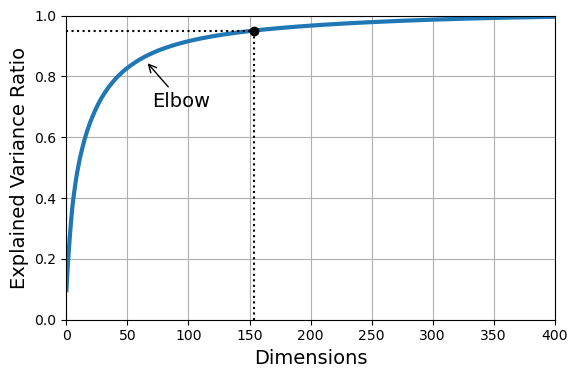

In [17]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance Ratio")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7), arrowprops=dict(arrowstyle="->"))
plt.grid(True)
save_fig("explained_variance_plot")
plt.show()

In [18]:
from sklearn.ensemble import  RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

clf = make_pipeline(PCA(random_state=42),
                    RandomForestClassifier(random_state=42))

param_distrib = {
    "pca__n_components": np.arange(10, 80),
    "randomforestclassifier__n_estimators": np.arange(50, 500)
}
rnd_search = RandomizedSearchCV(clf, param_distrib, n_iter=10, cv=3, random_state=42)
rnd_search.fit(X_train[:1000], y_train[:1000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       6...
       414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426,
       427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
       440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,
       453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
       466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478,
       479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491,
       492, 493, 494, 495, 496, 497, 498, 499])},
                   random_state=42)

In [19]:
print(rnd_search.best_params_)

{'randomforestclassifier__n_estimators': 465, 'pca__n_components': 23}


In [20]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

clf = make_pipeline(PCA(random_state=42), SGDClassifier())
param_grid = {"pca__n_components": np.arange(10, 80)}
grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X_train[:1000], y_train[:1000])

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                       ('sgdclassifier', SGDClassifier())]),
             param_grid={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
       78, 79])})

In [21]:
grid_search.best_params_

{'pca__n_components': 60}

## PCA for Compression

In [22]:
pca = PCA(0.95)
X_reduced = pca.fit_transform(X_train, y_train)

In [23]:
X_recovered = pca.inverse_transform(X_reduced)

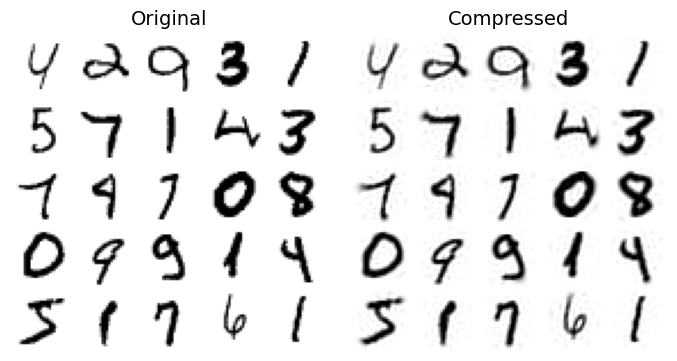

In [24]:
plt.figure(figsize=(7, 4))
for idx, X in enumerate((X_train[::2100], X_recovered[::2100])):
    plt.subplot(1, 2, idx + 1)
    plt.title(["Original", "Compressed"][idx])
    for row in range(5):
        for col in range(5):
            plt.imshow(X[row*5+col].reshape(28, 28), cmap="binary", vmin=0, vmax=255, extent=(row, row+1, col, col+1))
            plt.axis([0, 5, 0, 5])
            plt.axis("off")

save_fig("mnist_compression_plot")

### Randomized PCA

In [25]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

### Incremental PCA

In [26]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

**Using NumpPy's `memmap` class --a memory-map to an array stored in a binary file on disk**  

Let's create the `memmap` instance, copy the MNIST training set into it, and call `flush()` which ensures that any data still in cache is saved to disk. This would typically be done by a first program:

In [27]:
filename = "my_mnist.mmap"
X_mmpa = np.memmap(filename, dtype="float32", mode='write', shape=X_train.shape)
X_mmpa[:] = X_train         # Could be a loop instead, saving the data chunk by chunk
X_mmpa.flush()

Next, another program would load the data and use it for training:

In [28]:
X_mmpa = np.memmap(filename, dtype="float32", mode="readonly").reshape(-1, 784)
batch_size = X_mmpa.shape[0] // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mmpa)

IncrementalPCA(batch_size=600, n_components=154)

### Random Projection  

**Warning**: this sections will use close to 2.5 GB of RAM. If your computer runs out of memory, just reduce m and n:

In [29]:
from sklearn.random_projection import  johnson_lindenstrauss_min_dim

m, epsilon = 500, 0.5
d = johnson_lindenstrauss_min_dim(m, eps=epsilon) 
d

298

In [30]:
# show the equation computed by johnson_lindenstrauss_min_dim

d = int(4*np.log(m) / (epsilon**2 / 2 - epsilon**3 / 3))
d

298

In [31]:
n = 2_000
np.random.seed(42)
P = np.random.randn(d, n) / np.sqrt(d)      # std dev = square root of variance

X = np.random.randn(m, n)       # generate a fake dataset
X_reduced = X @ P.T

In [32]:
from sklearn.random_projection import GaussianRandomProjection

gaussian_rnd_proj = GaussianRandomProjection(eps=epsilon, random_state=42)
X_reduced = gaussian_rnd_proj.fit_transform(X)      # same result as above

**Warning**, the following cell may take several minutes to run.

In [33]:
components_pinv = np.linalg.pinv(gaussian_rnd_proj.components_)
X_recovered = X_reduced @ components_pinv.T

In [34]:
## performance comparison between Gaussian and Sparse RP

from sklearn.random_projection import SparseRandomProjection

print("GaussianRandomProjection fit")
%timeit GaussianRandomProjection(random_state=42).fit(X)
print("\nSparseRandomProjection fit")
%timeit SparseRandomProjection(random_state=42).fit(X)

gaussian_rnd_proj = GaussianRandomProjection(random_state=42).fit(X)
sparse_rnd_proj = SparseRandomProjection(random_state=42).fit(X)
print("GaussianRandomProjection transform")
%timeit gaussian_rnd_proj.transform(X)
print("SparseRandomProjection transform")
%timeit sparse_rnd_proj.transform(X)

GaussianRandomProjection fit


ValueError: eps=0.100000 and n_samples=500 lead to a target dimension of 5326 which is larger than the original space with n_features=2000

In [35]:
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import LocallyLinearEmbedding

X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_unrolled = lle.fit_transform(X_swiss)

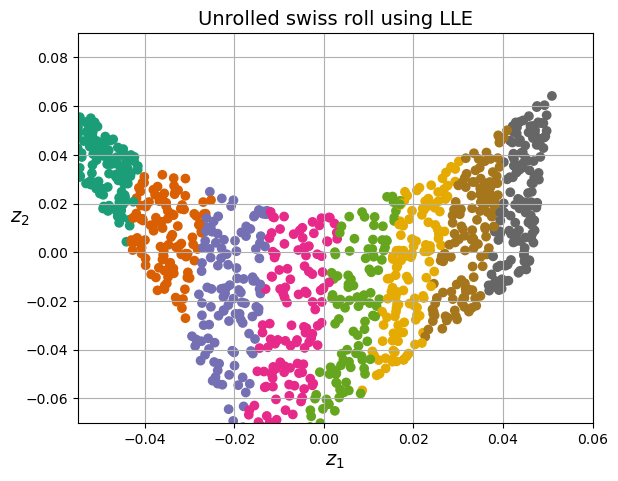

In [36]:
plt.scatter(X_unrolled[:, 0], X_unrolled[:, 1], c=t, cmap='Dark2_r')
plt.xlabel("$z_1$")
plt.ylabel("$z_2$", rotation=0)
plt.axis([-0.055, 0.060, -0.070, 0.090])
plt.grid(True)

save_fig("lle_unrolling_plot")
plt.title("Unrolled swiss roll using LLE")
plt.show()

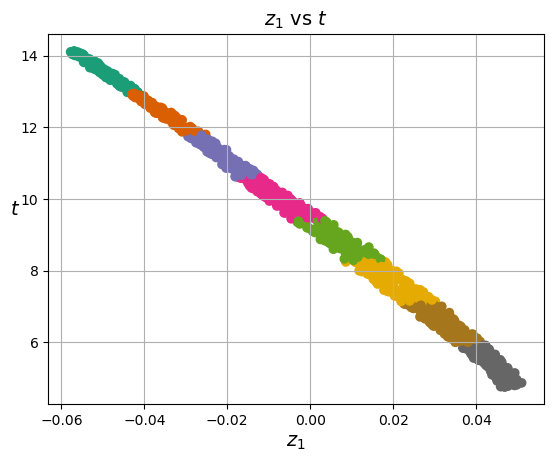

In [37]:
plt.title("$z_1$ vs $t$")
plt.scatter(X_unrolled[:, 0], t, c=t, cmap='Dark2_r')
plt.xlabel("$z_1$")
plt.ylabel("$t$", rotation=0)
plt.grid(True)
plt.show()

Note: we added `normalized_stress=False` below to avoid a warning about the fact that the default value for that hyperparameter will change in the future. 

In [38]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, normalized_stress=False, random_state=42)
X_reduced_mds = mds.fit_transform(X_swiss)

In [39]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2) 
X_reduced_isomap = isomap.fit_transform(X_swiss)

In [40]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init="random", learning_rate="auto", random_state=42)
X_reduced_tsne = tsne.fit_transform(X_swiss)

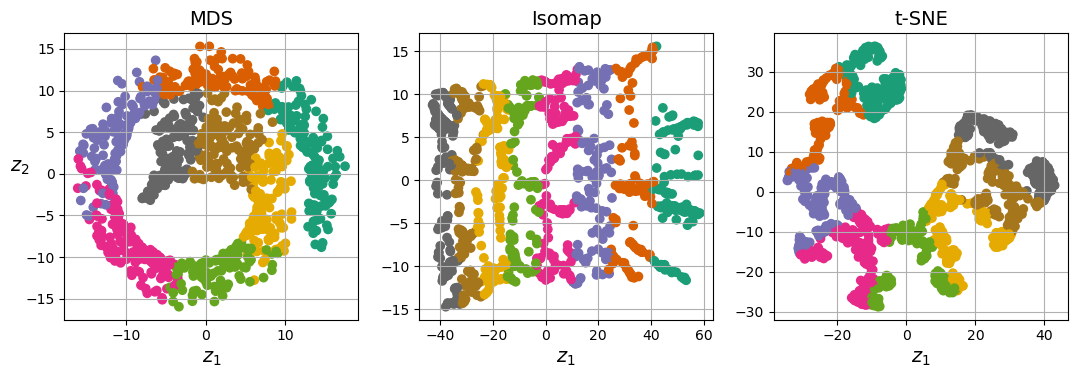

In [41]:
# This cell generates and saves figure

titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11, 4))

for subplot, title, X_reduced in zip((131, 132, 133), titles, (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap='Dark2_r')
    plt.xlabel("$z_1$")
    if subplot == 131:
        plt.ylabel("$z_2$", rotation=0)
    plt.grid(True)
    
save_fig("other_dim_reduction_plot")
plt.show()

## Extra Material - Kernel PCA

In [42]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.04, random_state=42)
X_reduced = rbf_pca.fit_transform(X_swiss)

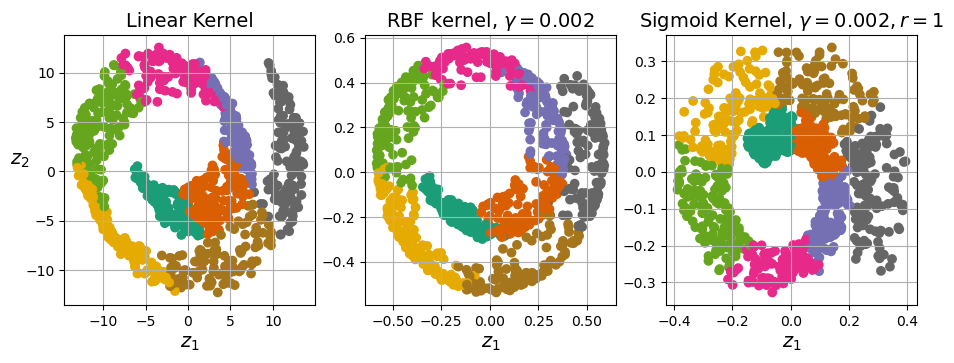

In [43]:
lin_pca = KernelPCA(kernel="linear")
rbf_pca = KernelPCA(kernel="rbf", gamma=0.002)
sig_pca = KernelPCA(kernel="sigmoid", gamma=0.002, coef0=1)

kernel_pcas = ((lin_pca, "Linear Kernel"),
               (rbf_pca, rf"RBF kernel, $\gamma={rbf_pca.gamma}$"),
               (sig_pca, rf"Sigmoid Kernel, $\gamma={sig_pca.gamma}, r={sig_pca.coef0}$"))

plt.figure(figsize=(11, 3.5))
for idx, (kpca, title) in enumerate(kernel_pcas):
    kpca.n_components = 2
    kpca.n_components = 42
    X_reduced = kpca.fit_transform(X_swiss)
    
    plt.subplot(1, 3, idx + 1)
    plt.title(title)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.Dark2)
    plt.xlabel("$z_1$")
    if idx == 0:
        plt.ylabel("$z_2$", rotation=0)
    plt.grid()
    
plt.show()

## Exercice solutions

### 1. to 8. 

1. The main motivations for dimensionality reduction are:  

* To speed up a subsequent training algorithm (in some cases it may even remove noise and redundant features, making the training algorithm perform better)  
* To visualize the data and gain insights on the most important features   
* To save space (compression)   
The main drawbacks are:
  
* Some information is lost, possibly degrading the performance of subsequent training algorithms.  
* It can be computationally intensive.  
* It adds some complexity to your Machine Learning pipelines.  
* Transformed features are often hard to interpret.  
2. The curse of dimensionality refers to the fact that many problems that do not exist in low-dimensional space arise in high-dimensional space. In Machine Learning, one common manifestation is the fact that randomly sampled high-dimensional vectors are generally far from one another, increasing the risk of overfitting and making it very difficult to identify patterns without having plenty of training data.  

3. Once a dataset's dimensionality has been reduced using one of the algorithms we discussed, it is almost always impossible to perfectly reverse the operation, because some information gets lost during dimensionality reduction. Moreover, while some algorithms (such as PCA) have a simple reverse transformation procedure that can reconstruct a dataset relatively similar to the original, other algorithms (such as t-SNE) do not.  

4. PCA can be used to significantly reduce the dimensionality of most datasets, even if they are highly nonlinear, because it can at least get rid of useless dimensions. However, if there are no useless dimensions—as in the Swiss roll dataset—then reducing dimensionality with PCA will lose too much information. You want to unroll the Swiss roll, not squash it.

5. That's a trick question: it depends on the dataset. Let's look at two extreme examples. First, suppose the dataset is composed of points that are almost perfectly aligned. In this case, PCA can reduce the dataset down to just one dimension while still preserving 95% of the variance. Now imagine that the dataset is composed of perfectly random points, scattered all around the 1,000 dimensions. In this case roughly 950 dimensions are required to preserve 95% of the variance. So the answer is, it depends on the dataset, and it could be any number between 1 and 950. Plotting the explained variance as a function of the number of dimensions is one way to get a rough idea of the dataset's intrinsic dimensionality.  

6. Regular PCA is the default, but it works only if the dataset fits in memory. Incremental PCA is useful for large datasets that don't fit in memory, but it is slower than regular PCA, so if the dataset fits in memory you should prefer regular PCA. Incremental PCA is also useful for online tasks, when you need to apply PCA on the fly, every time a new instance arrives. Randomized PCA is useful when you want to considerably reduce dimensionality and the dataset fits in memory; in this case, it is much faster than regular PCA. Finally, Random Projection is great for very high-dimensional datasets.  

7. Intuitively, a dimensionality reduction algorithm performs well if it eliminates a lot of dimensions from the dataset without losing too much information. One way to measure this is to apply the reverse transformation and measure the reconstruction error. However, not all dimensionality reduction algorithms provide a reverse transformation. Alternatively, if you are using dimensionality reduction as a preprocessing step before another Machine Learning algorithm (e.g., a Random Forest classifier), then you can simply measure the performance of that second algorithm; if dimensionality reduction did not lose too much information, then the algorithm should perform just as well as when using the original dataset.  

8. It can absolutely make sense to chain two different dimensionality reduction algorithms. A common example is using PCA or Random Projection to quickly get rid of a large number of useless dimensions, then applying another much slower dimensionality reduction algorithm, such as LLE. This two-step approach will likely yield roughly the same performance as using LLE only, but in a fraction of the time.  

### 9.  

*Exercise: Load the MNIST dataset and split it into a training set and a test set (take the first 60,000 instances for training, and the remaining 10,000 for testing).*

In [44]:
X_train = mnist.data[:60000]
y_train = mnist.target[:60000]

X_test = mnist.data[60000:]
y_test = mnist.target[60000:]

* *Exercise: Train a Random Forest classifier on the dataset and time how long it takes, then evaluate the resulting model on the test set.*

In [45]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)

In [46]:
%time rnd_clf.fit(X_train, y_train)

CPU times: total: 27.4 s
Wall time: 1min 11s


RandomForestClassifier(random_state=42)

In [47]:
from sklearn.metrics import accuracy_score

y_pred = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred)  

0.9705

* *Exercise: Next, use PCA to reduce the dataset's dimensionality, with an explained variance ratio of 95%.*

In [49]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)

* *Exercise: Train a new Random Forest classifier on the reduced dataset and see how long it takes. Was training much faster?*

In [50]:
rnd_clf_with_pca = RandomForestClassifier(n_estimators=100, random_state=42)
%time rnd_clf_with_pca.fit(X_train_reduced, y_train)

CPU times: total: 1min 43s
Wall time: 4min 20s


RandomForestClassifier(random_state=42)

Oh no! Training is actually about twice slower now. Well, as we saw in this chapter, dimensionality reduction does not always lead to faster training time: it depends on the dataset, the model and the training algorithm. If you try SGDClassifier instead of RandomForestClassifier, you will find that training time is reduced by a factor of 3 when using PCA. Actually, we will do this in a second, but first let's check the precision of the new random forest classifier.  

* *Exercise: Next evaluate the classifier on the test set: how does it compare to the previous classifier?*

In [51]:
X_test_reduced = pca.transform(X_test)

y_pred = rnd_clf_with_pca.predict(X_test_reduced)
accuracy_score(y_test, y_pred)  

0.9481

It is common for performance to drop slightly when reducing dimensionality, because we do lose some potentially useful signal in the process. However, the performance drop is rather severe in this case. So PCA really did not help: it slowed down training and reduced performance.

* *Exercise: Try again with an SGDClassifier. How much does PCA help now?*

In [52]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
%time sgd_clf.fit(X_train, y_train)

CPU times: total: 57 s
Wall time: 2min 37s


SGDClassifier(random_state=42)

In [53]:
y_pred = sgd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.874

Okay, so the `SGDClassifier` takes much longer to train on this dataset than the `RandomForestClassifier`, plus it performs worse on the test set. But that's not what we are interested in right now, we want to see how much PCA can help `SGDClassifier`. Let's train it using the reduced dataset:

In [54]:
sgd_clf_with_pca = SGDClassifier(random_state=42)
%time sgd_clf_with_pca.fit(X_train_reduced, y_train)

CPU times: total: 10.1 s
Wall time: 35.9 s


SGDClassifier(random_state=42)

Nice! Reducing dimensionality led to roughly 5× speedup. :) Let's check the model's accuracy:

In [55]:
y_pred = sgd_clf_with_pca.predict(X_test_reduced)
accuracy_score(y_test, y_pred)  

0.8959

Great! PCA not only gave us a 5× speed boost, it also improved performance slightly.

So there you have it: PCA can give you a formidable speedup, and if you're lucky a performance boost... but it's really not guaranteed: it depends on the model and the dataset!

### 10.  

* *Exercise: Use t-SNE to reduce the first 5,000 images of the MNIST dataset down to two dimensions and plot the result using Matplotlib. You can use a scatterplot using 10 different colors to represent each image's target class.*

Let's limit ourselves to the first 5,000 images of the MNIST training set, to speed things up a lot.

In [56]:
X_sample, y_sample = X_train[:5000], y_train[:5000]

Let's use t-SNE to reduce dimensionality down to 2D so we can plot the dataset:

In [57]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init="random", learning_rate="auto", random_state=42)

%time X_reduced = tsne.fit_transform(X_sample)

CPU times: total: 1min 49s
Wall time: 27.9 s


Now let's use Matplotlib's `scatter()` function to plot a scatterplot, using a different color for each digit:

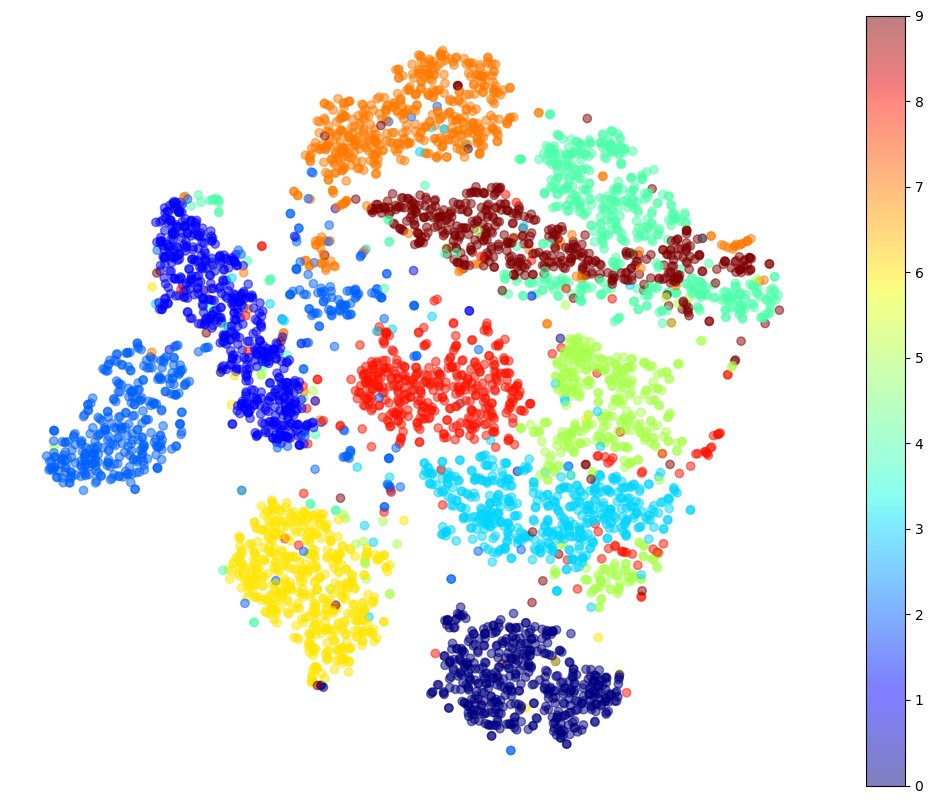

In [58]:
plt.figure(figsize=(13, 10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_sample.astype(np.int8), cmap="jet", alpha=0.5)

plt.axis("off")
plt.colorbar()
plt.show()

Isn't this just beautiful? :) Most digits are nicely separated from the others, even though t-SNE wasn't given the targets: it just identified clusters of similar images. But there is still a bit of overlap. For example, the 3s and the 5s overlap a lot (on the right side of the plot), and so do the 4s and the 9s (in the top-right corner).

Let's focus on just the digits 4 and 9:

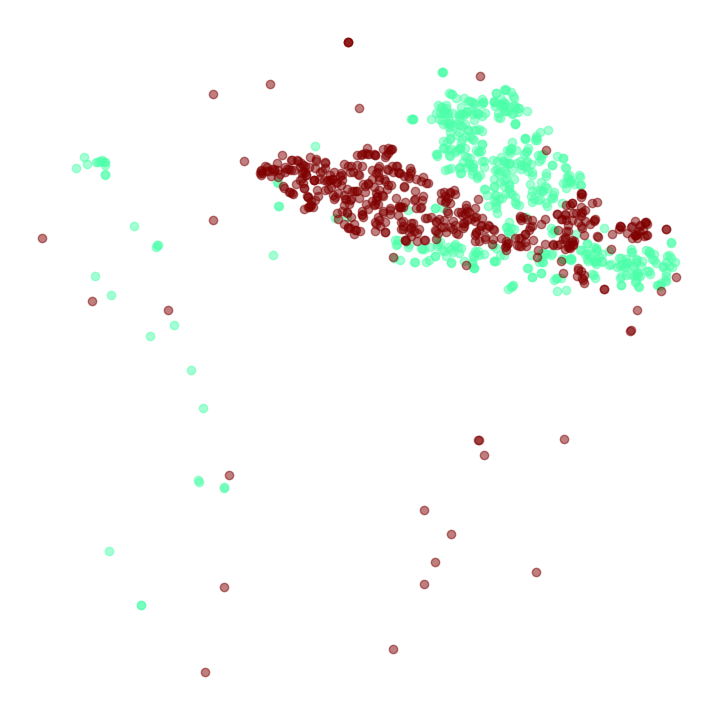

In [59]:
plt.figure(figsize=(9, 9))
cmap = plt.cm.jet
for digit in ('4', '9'):
    plt.scatter(X_reduced[y_sample == digit, 0], X_reduced[y_sample == digit, 1],
                c=[cmap(float(digit) / 9)], alpha=0.5)
plt.axis('off')
plt.show()

Let's see if we can produce a nicer image by running t-SNE on just these 2 digits:

In [60]:
idx = (y_sample == '4') | (y_sample == '9')
X_subset = X_sample[idx]
y_subset = y_sample[idx]

tsne_subset = TSNE(n_components=2, init="random", learning_rate="auto",
                   random_state=42)
X_subset_reduced = tsne_subset.fit_transform(X_subset)

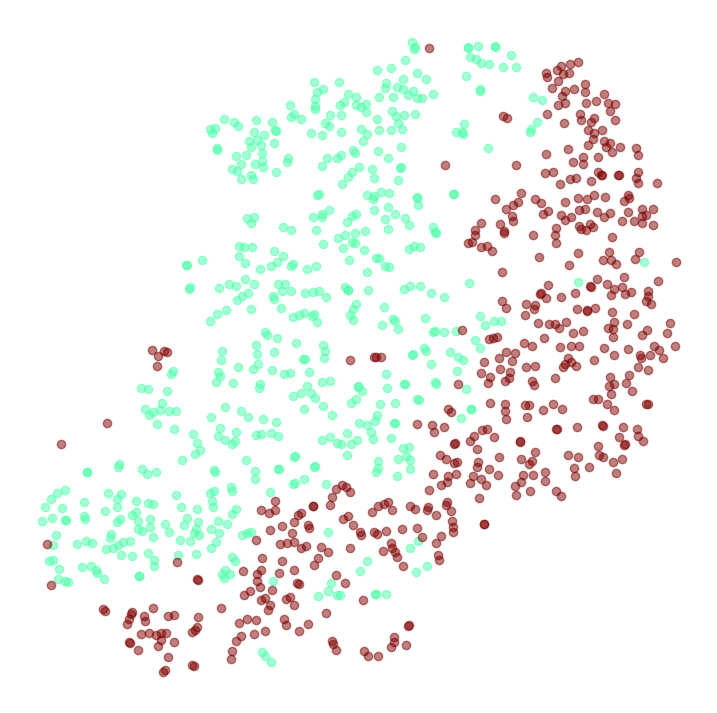

In [61]:
plt.figure(figsize=(9, 9))
for digit in ('4', '9'):
    plt.scatter(X_subset_reduced[y_subset == digit, 0],
                X_subset_reduced[y_subset == digit, 1],
                c=[cmap(float(digit) / 9)], alpha=0.5)
plt.axis('off')
plt.show()

That's much better, although there's still a bit of overlap. Perhaps some 4s really do look like 9s, and vice versa. It would be nice if we could visualize a few digits from each region of this plot, to understand what's going on. In fact, let's do that now.

* *Exercise: Alternatively, you can replace each dot in the scatterplot with the corresponding instance’s class (a digit from 0 to 9), or even plot scaled-down versions of the digit images themselves (if you plot all digits, the visualization will be too cluttered, so you should either draw a random sample or plot an instance only if no other instance has already been plotted at a close distance). You should get a nice visualization with well-separated clusters of digits.*

Let's create a `plot_digits()` function that will draw a scatterplot (similar to the above scatterplots) plus write colored digits, with a minimum distance guaranteed between these digits. If the digit images are provided, they are plotted instead. 

In [62]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_digits(X, y, min_distance=0.04, images=None, figsize=(13, 10)):
    # Let's scale the input features so that they range from 0 to 1
    X_normalized = MinMaxScaler().fit_transform(X)
    # Now we create the list of coordinates of the digits plotted so far.
    # We pretend that one is already plotted far away at the start, to avoid 'if' statements in the loop below.
    neighbors = np.array([[10., 10.]])
    # The rest should be self-explanatory
    plt.figure(figsize=figsize)
    cmap = plt.cm.jet
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1], c=[cmap(float(digit) / 9)], alpha=0.5)
    plt.axis("off")
    ax = plt.gca()  #get current axes
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(neighbors - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])), color=cmap(float(y[index])/ 9), 
                         fontdict = {"weight": "bold", "size": 16})
            else:
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"), image_coord)
                ax.add_artist(imagebox)

Let's try it! First let's show colored digits (not images), for all 5,000 images:

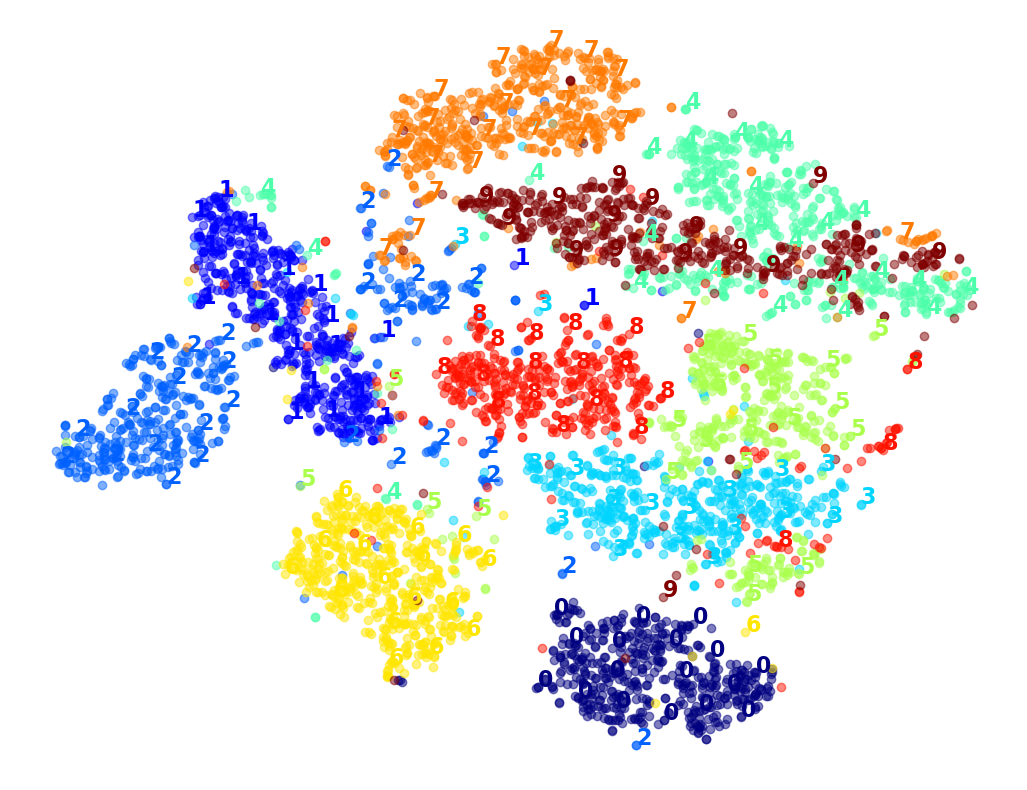

In [63]:
plot_digits(X_reduced, y_sample)

Well that's okay, but not that beautiful. Let's try with the digit images:

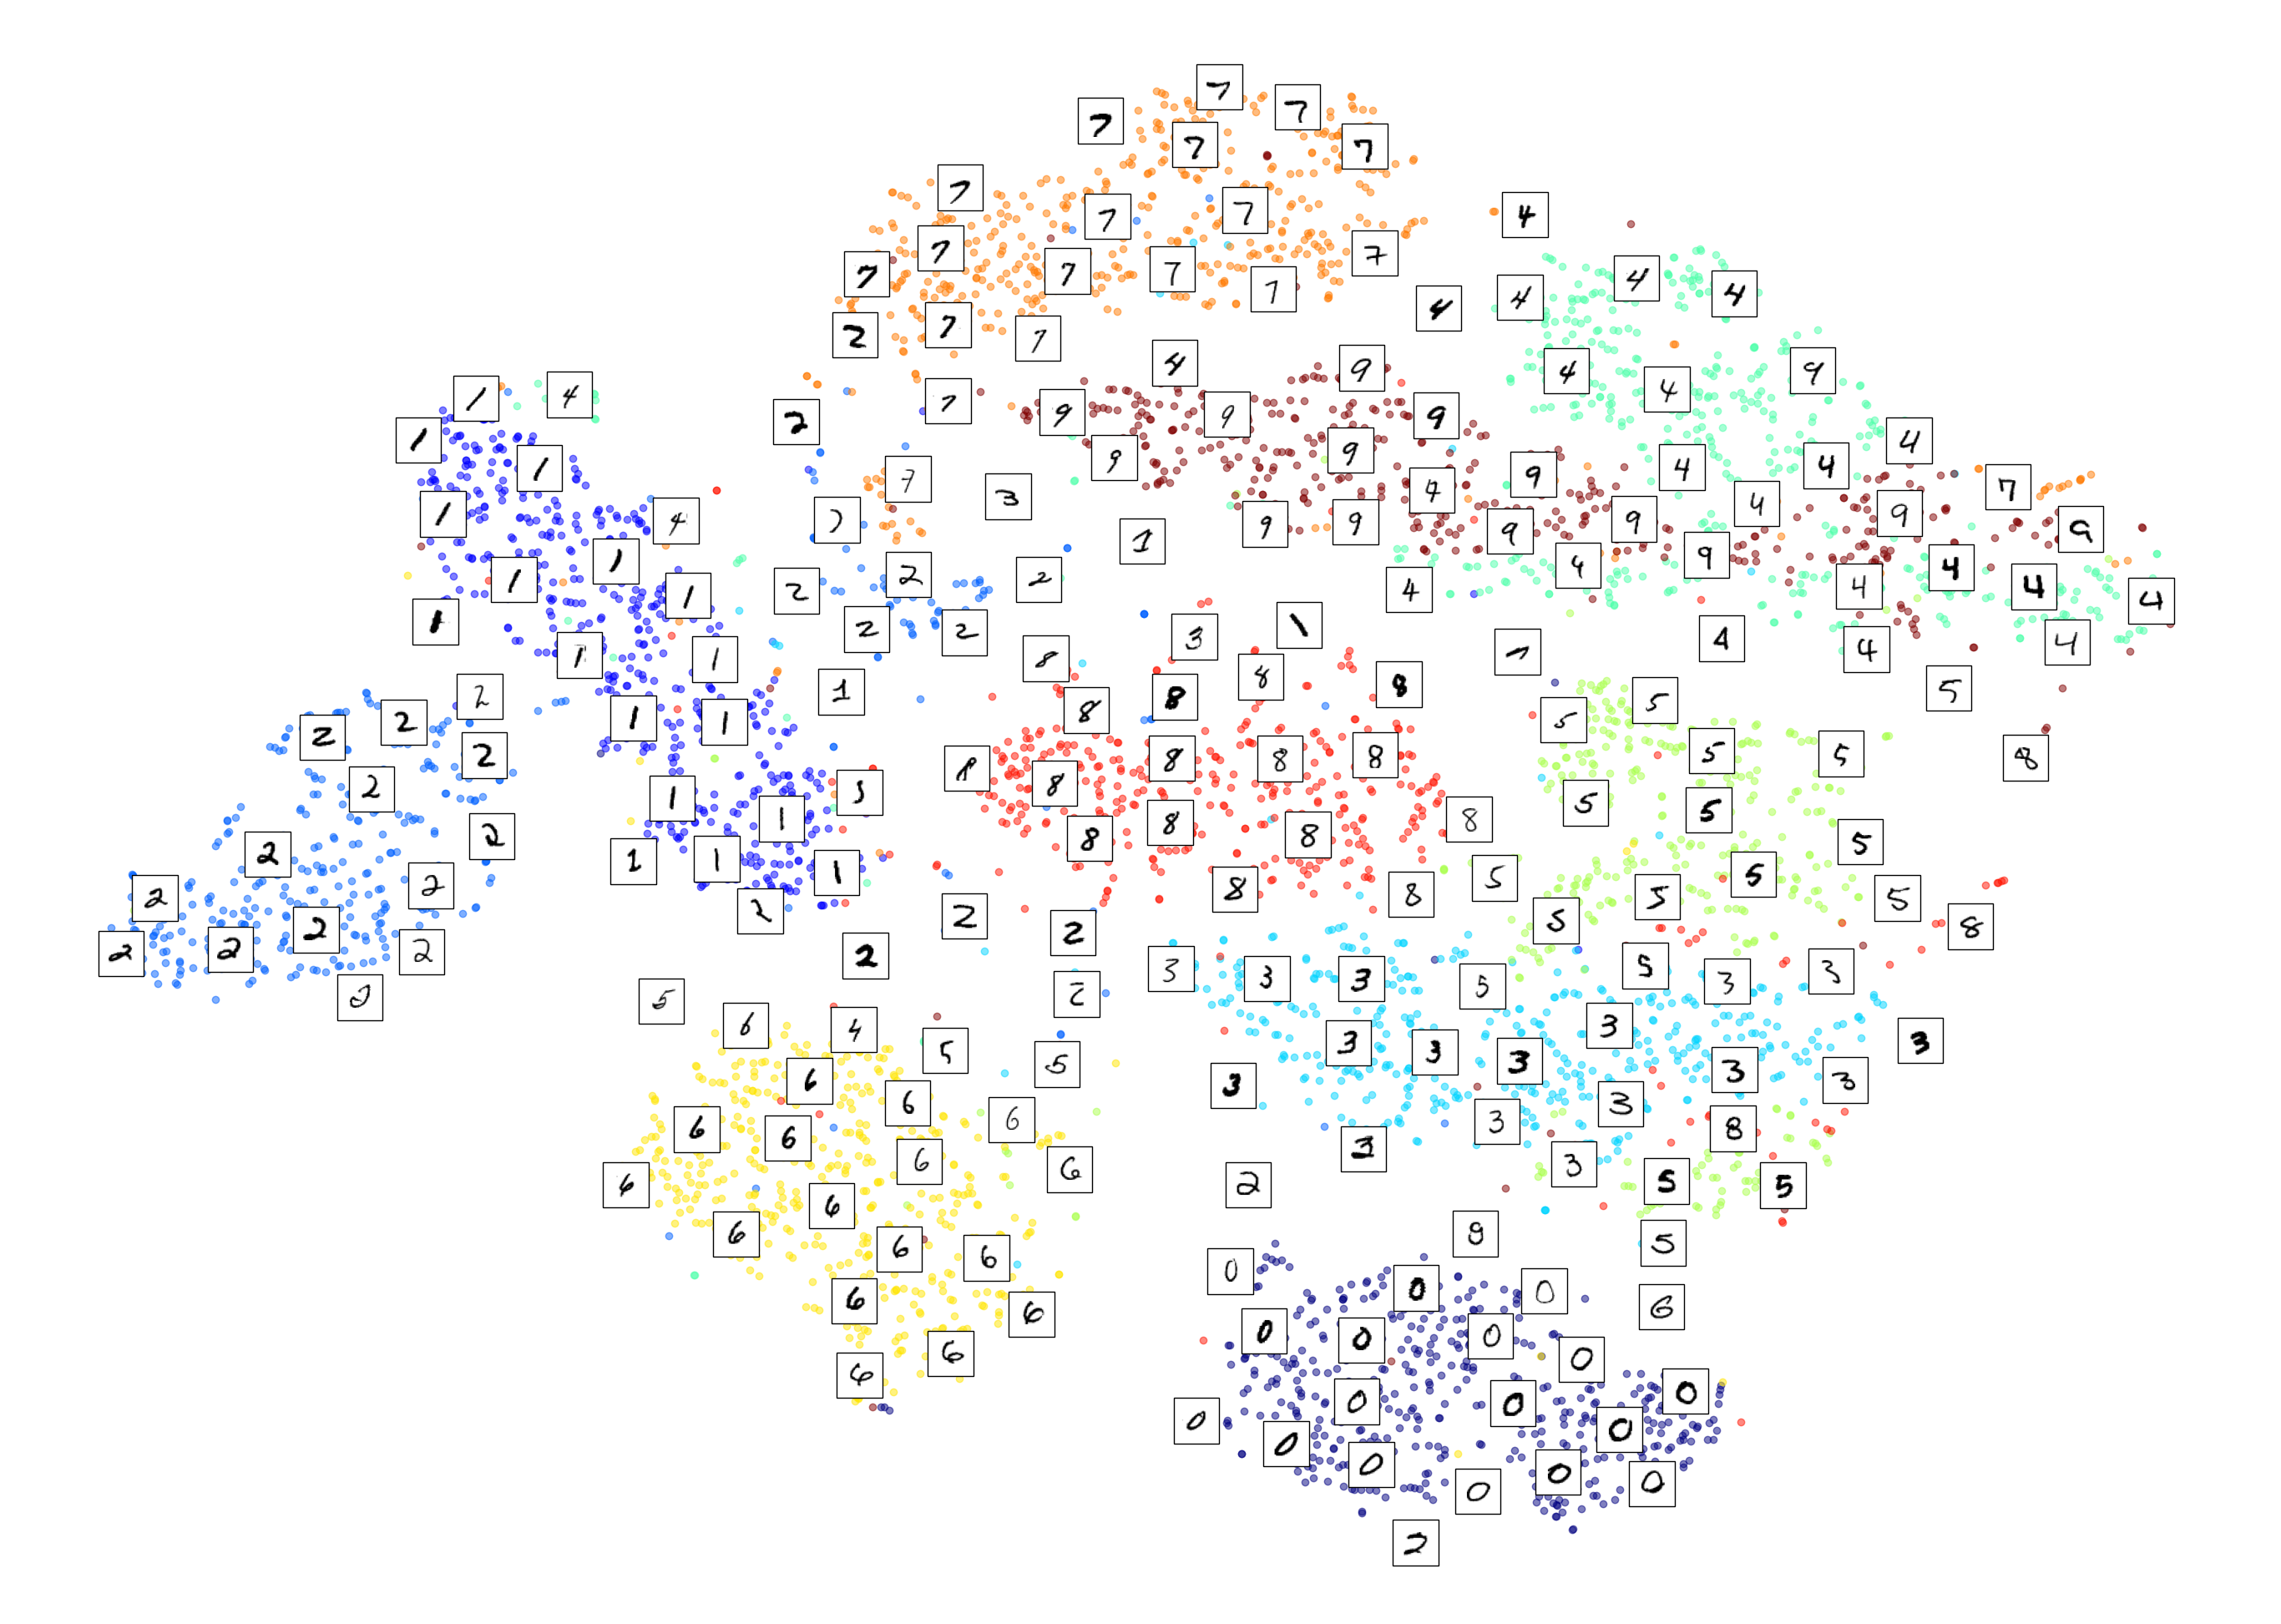

In [64]:
plot_digits(X_reduced, y_sample, images=X_sample, figsize=(35, 25))

That's nicer! Now let's focus on just the 4s and the 9s:

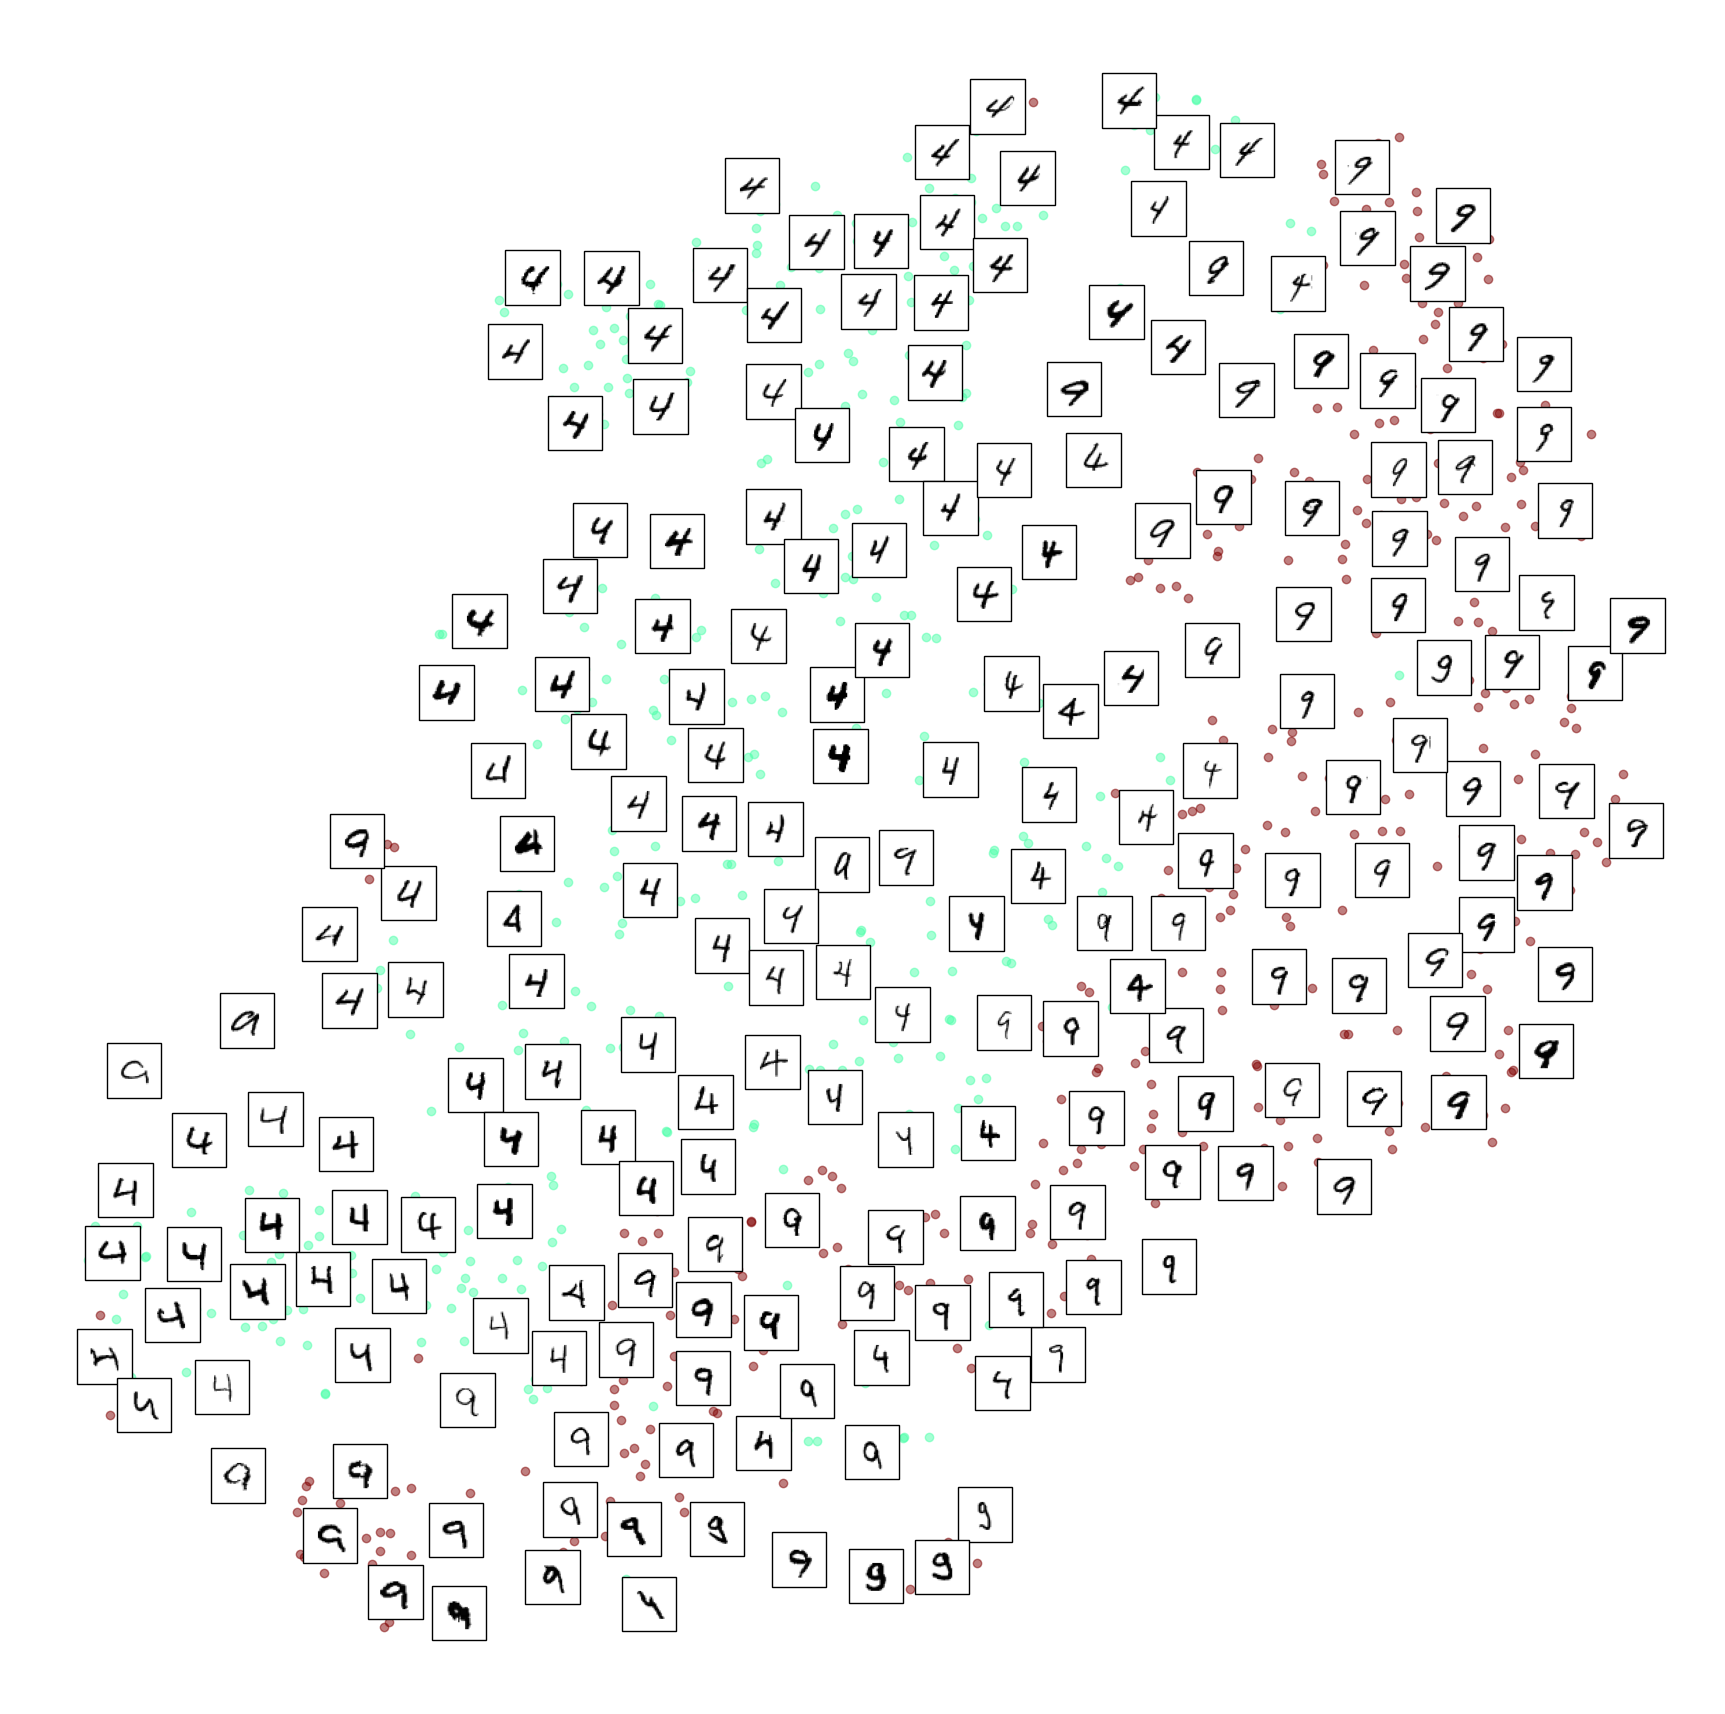

In [65]:
plot_digits(X_subset_reduced, y_subset, images=X_subset, figsize=(22, 22))

Notice how similar-looking 4s are grouped together. For example, the 4s get more and more inclined as they approach the top of the figure. The inclined 9s are also closer to the top. Some 4s really do look like 9s, and vice versa.

* *Exercise: Try using other dimensionality reduction algorithms such as PCA, LLE, or MDS and compare the resulting visualizations.*

Let's start with PCA. We will also time how long it takes:

CPU times: total: 500 ms
Wall time: 368 ms


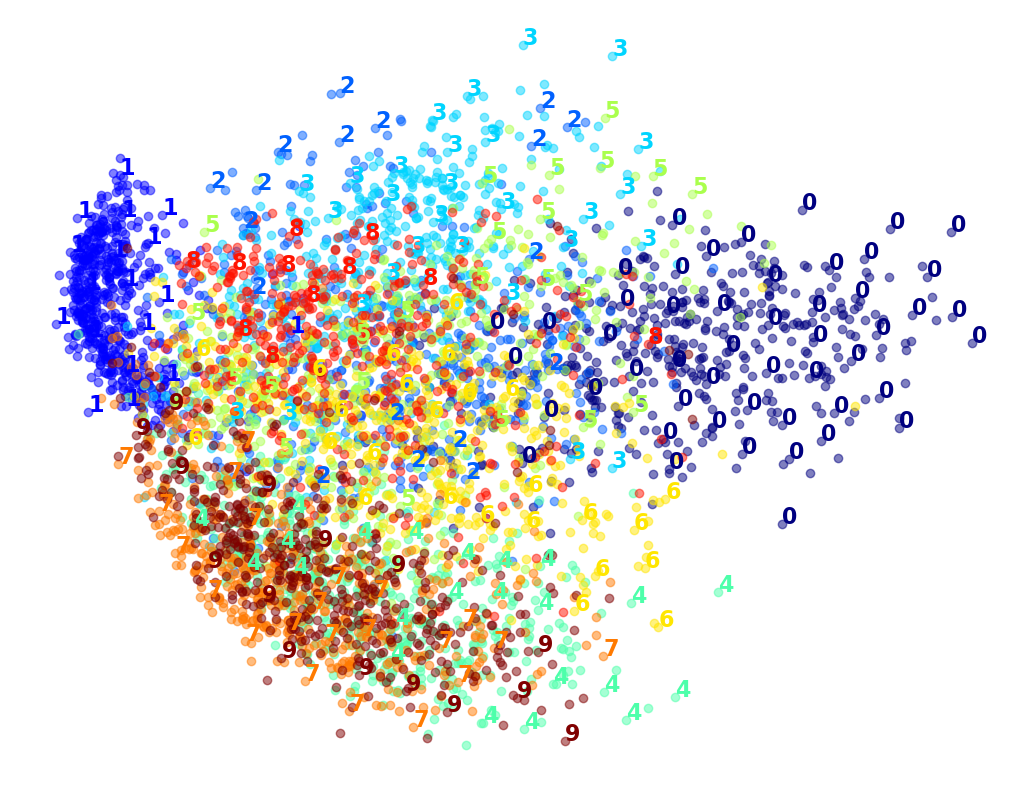

In [66]:
pca = PCA(n_components=2, random_state=42)
%time X_pca_reduced = pca.fit_transform(X_sample)
plot_digits(X_pca_reduced, y_sample)
plt.show()

Wow, PCA is blazingly fast! But although we do see a few clusters, there's way too much overlap. Let's try LLE:

CPU times: total: 6.56 s
Wall time: 3.05 s


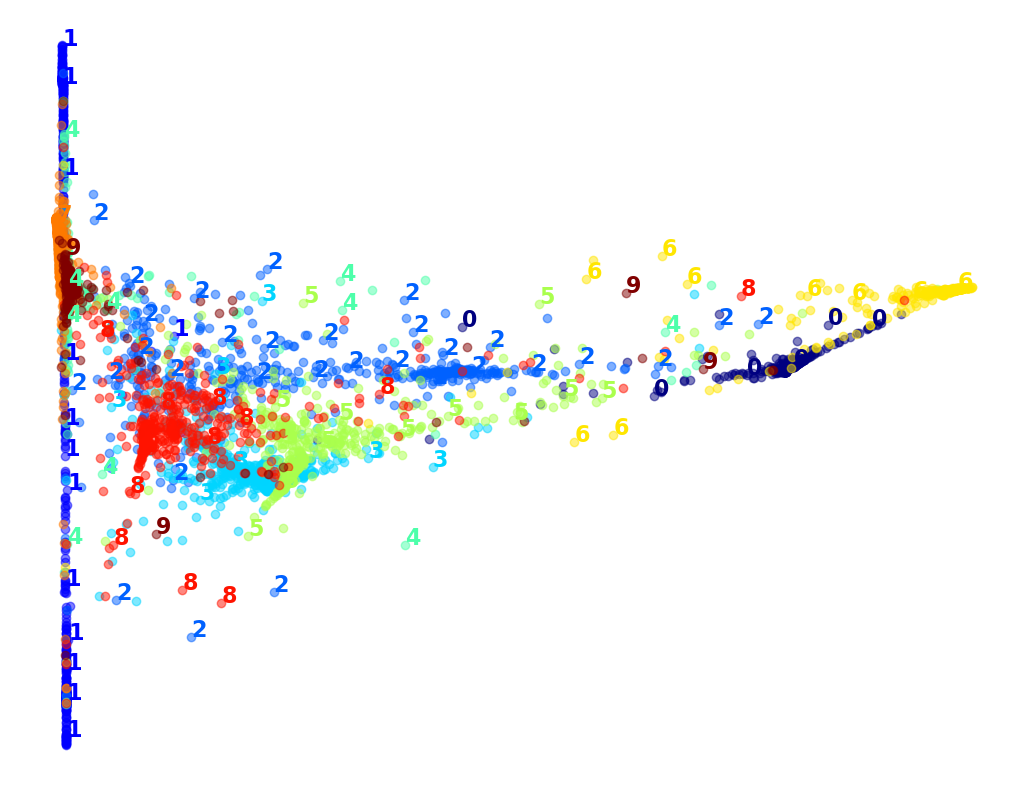

In [67]:
lle = LocallyLinearEmbedding(n_components=2, random_state=42)
%time X_lle_reduced = lle.fit_transform(X_sample)
plot_digits(X_lle_reduced, y_sample)
plt.show()

That took more time, and yet the result does not look good at all. Let's see what happens if we apply PCA first, preserving 95% of the variance:

CPU times: total: 12.3 s
Wall time: 4.24 s


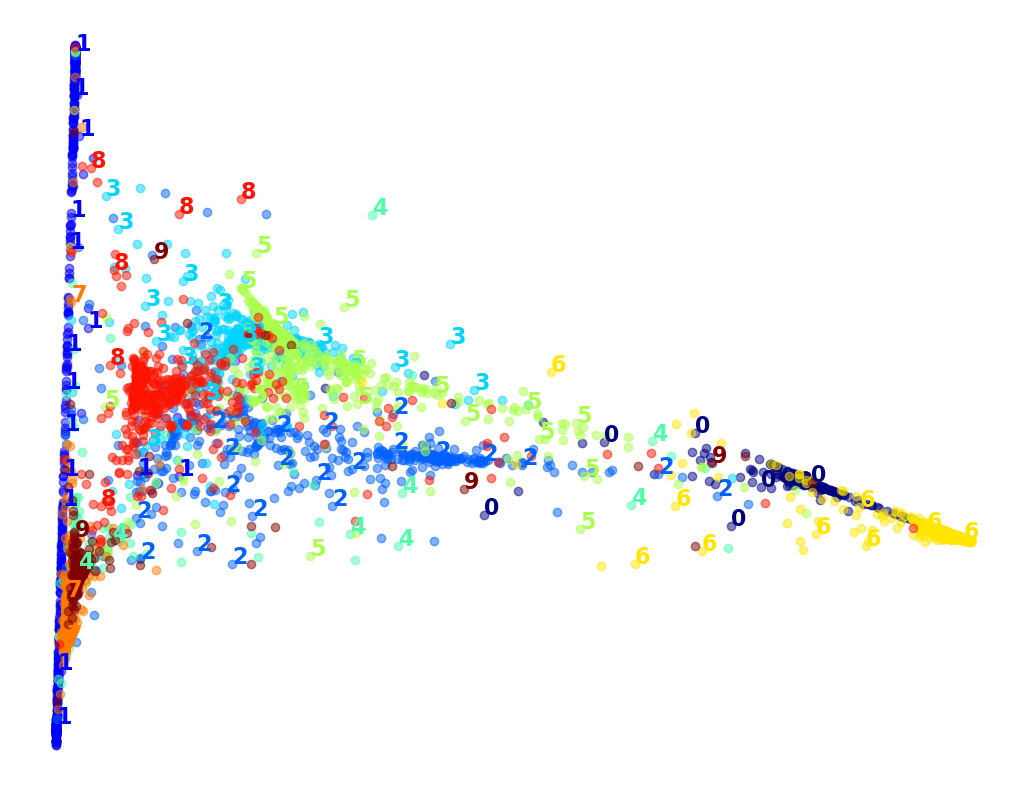

In [68]:
pca_lle = make_pipeline(PCA(n_components=0.95),
                        LocallyLinearEmbedding(n_components=2, random_state=42))

%time X_pca_lle_reduced = pca_lle.fit_transform(X_sample)
plot_digits(X_pca_lle_reduced, y_sample)
plt.show()

The result is more or less as bad, but this time training was a bit faster.

Let's try MDS:

**Warning**, the following cell will take about 10-30 minutes to run, depending on your hardware:

CPU times: total: 29min 13s
Wall time: 16min 11s


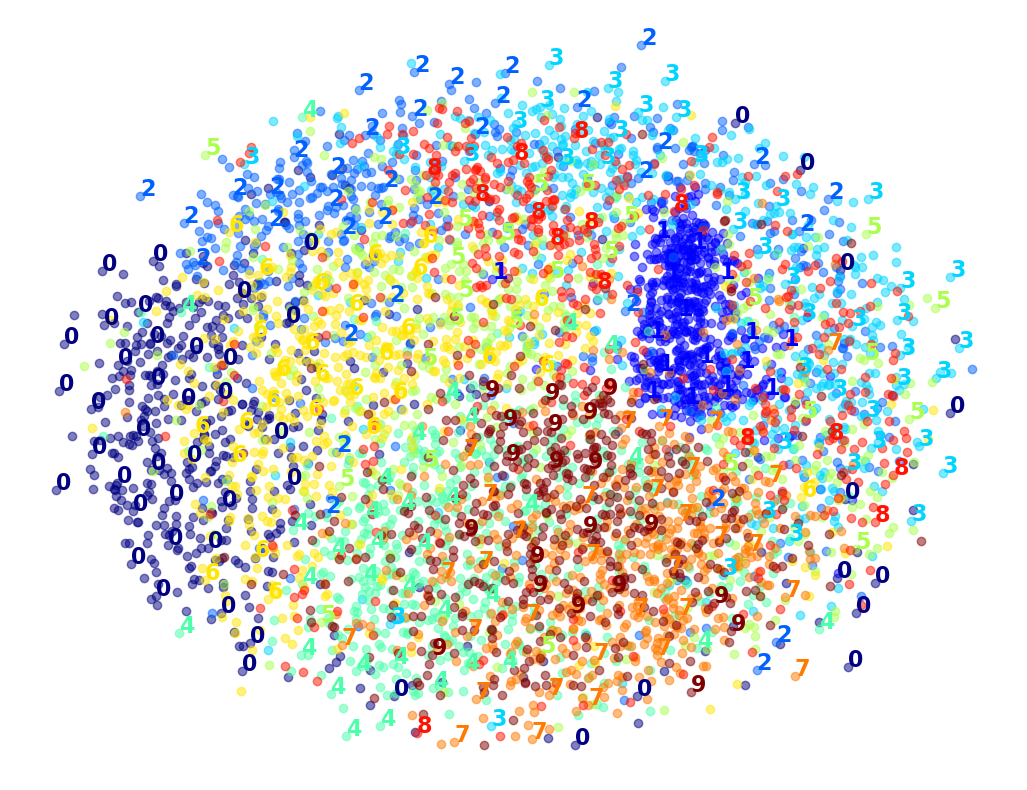

In [69]:
%time X_mds_reduced = MDS(n_components=2, normalized_stress=False, random_state=42).fit_transform(X_sample)
plot_digits(X_mds_reduced, y_sample)
plt.show()

Meh. This does not look great, all clusters overlap too much. Let's try with PCA first, perhaps it will be faster?

**Warning**, the following cell will take about 10-30 minutes to run, depending on your hardware:

CPU times: total: 30min 53s
Wall time: 16min 26s


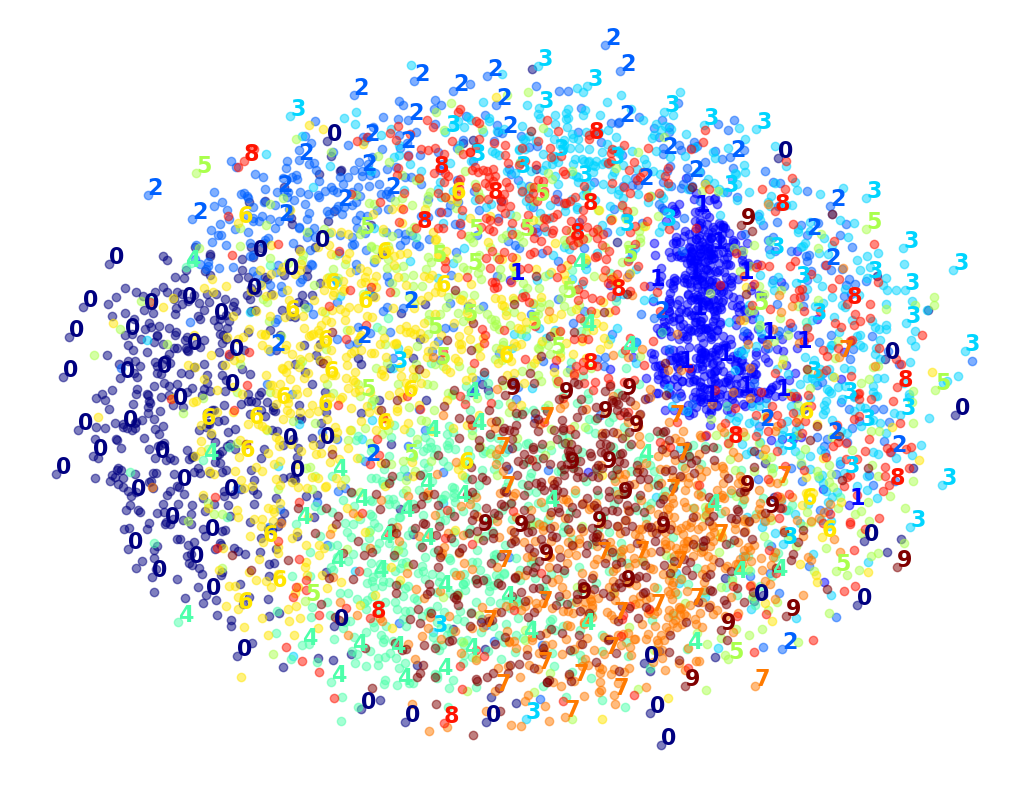

In [70]:
pca_mds = make_pipeline(
    PCA(n_components=0.95, random_state=42),
    MDS(n_components=2, normalized_stress=False, random_state=42)
)

%time X_pca_mds_reduced = pca_mds.fit_transform(X_sample)
plot_digits(X_pca_mds_reduced, y_sample)
plt.show()

Same result, and not faster: PCA did not help in this case.

Let's try LDA now:

CPU times: total: 12.4 s
Wall time: 3.84 s


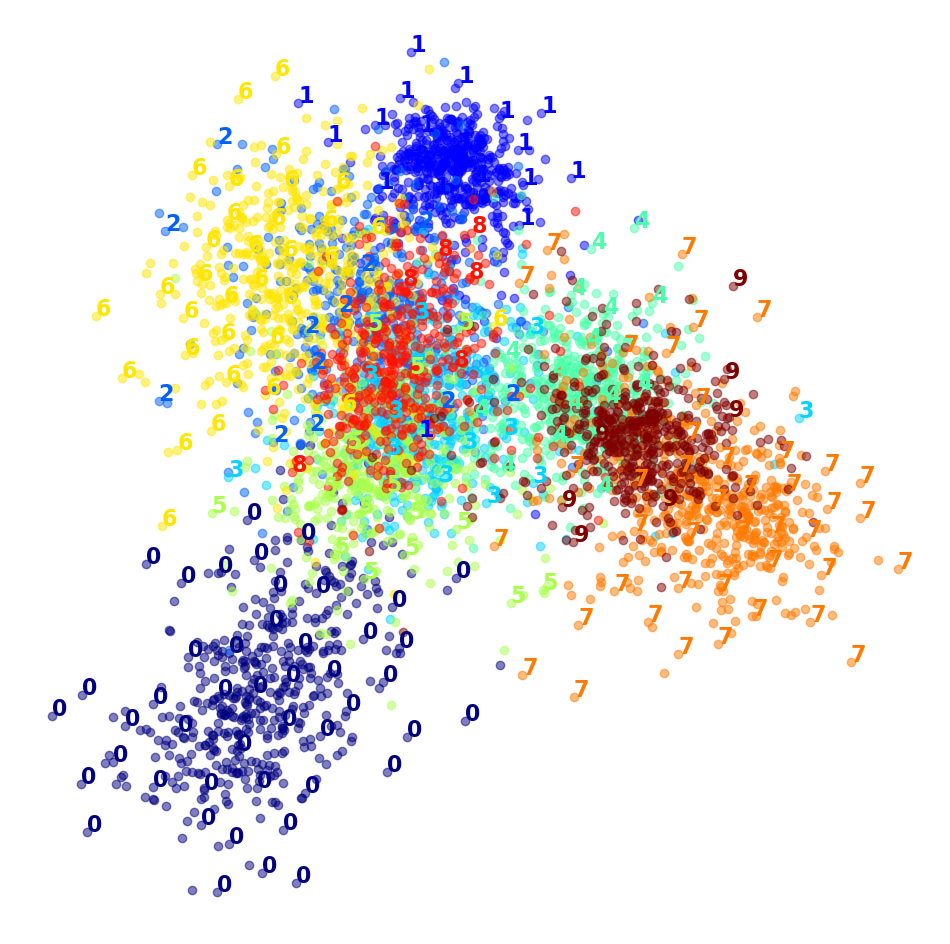

In [73]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

ldaa = LinearDiscriminantAnalysis(n_components=2)
%time X_lda_reduced = ldaa.fit_transform(X_sample, y_sample)
plot_digits(X_lda_reduced, y_sample, figsize=(12, 12))
plt.show()

This one is very fast, and it looks nice at first, until you realize that several clusters overlap severely.

Well, it's pretty clear that t-SNE won this little competition, wouldn't you agree ?